### Dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/pmoha/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Neural Network Methods (EMNIST)

Utilizing neural network methods and comparing their effectiveness through their test accuracy. No need to utilize ROC curves as the provided classes are balanced, also not requiring the need of class balancing methods. 
<br><br>Three exclusively neural network approaches: 
* Multilayer perceptron (MLP)
* Convolution Neural Network (CNN)
* Visual Transformer (ViT)

## Data Loading (No Augmentation)

For the sake of computation power and time we are utilizing the letters split of the EMNIST dataset which is a subset containing only 26 classes. This combines both uppercase and lowercase into a single class, and has the additional benefit of having equal counts across all classes.

In [4]:
def load_dataset(download_dir, download_needed, batch_size, t, t1):
    train_set = torchvision.datasets.EMNIST(
        root=download_dir,
        split="letters",
        train=True,
        download=download_needed,
        transform=transforms.Compose(t)
    )

    train_loader = DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True,
        pin_memory=True
    )

    test_set = torchvision.datasets.EMNIST(
        root=download_dir,
        split="letters",
        train=False,
        download=download_needed,
        transform=transforms.Compose(t1)
    )

    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    return train_loader, train_set, test_loader, test_set

download_dir = "./downloads"
batch_size = 1024

train_loader, train_set, test_loader, test_set = load_dataset(download_dir, True, batch_size, [transforms.ToTensor()], [transforms.ToTensor()])


20
t


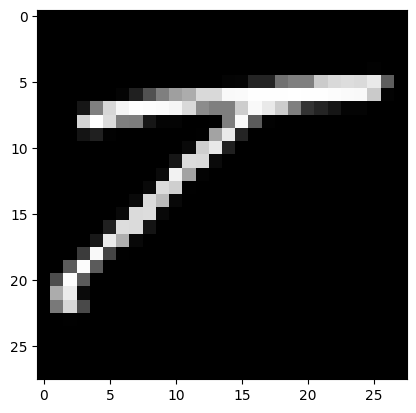

In [12]:
index = 50

for temp, i in enumerate(train_set):
    label = i[1]
    if label != 20:
        continue
    print(label)
    print(chr(ord("a") + label - 1))
    image = i[0].numpy()[0].T
    plt.imshow(image, cmap="gray")
    break

In [3]:
print("Training Examples: ", len(train_set))
print("Testing Examples: ", len(test_set))

Training Examples:  124800
Testing Examples:  20800


## Multilayer Perceptron (MLP)
We will be training an MLP model on the EMNIST dataset while changing the hyperparameters to see which best suites the task at hand. We will be tuning the number of hidden layers and the dimension of the hidden layers, and training each combination on 15 epochs for the sake of time and efficiency.

In [5]:
class MLP(nn.Module):

    # Initialize network with hidden_layers + 2 (input and output l layers)
    def __init__(self, input_dim, hidden_dim, hidden_layers):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())
        self.dropout = nn.Dropout(p=0.4)

        for _ in range(hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(self.dropout)

        self.layers.append(nn.Linear(hidden_dim, 26))

    # Define forward pass to output logits and loss if provided
    def forward(self, vals: torch.Tensor, targets: torch.Tensor = None):
        for layer in self.layers:
            vals = layer(vals)

        if targets != None:
            loss = F.cross_entropy(vals, targets)
        else:
            loss = None

        return vals, loss
    
    
    def __str__(self):
        retString = f"MLP Model with {len(self.layers) + 2} Layers\n\n"

        for i, layer in enumerate(self.layers):
            retString += f"({i}) " + layer.__str__() + "\n"

        return retString
    
def test_accuracy(model, data_loader, input_dim=28*28, cnn=False):
    model.eval()
    correct_predictions = 0

    for data, labels in data_loader:
        data = data.to(device)
        labels = labels.to(device)
        labels = labels - 1

        if not cnn:
            data = data.view(-1, input_dim)
        logits, loss = model(data)
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1)
        correct_predictions += sum(predicted_class == labels) / len(data)

    return correct_predictions / len(data_loader)

def train_model(model, num_epochs, train_loader, optim, input_dim=28*28, cnn=False):
    model.train()

    loss_arr = []

    for i in range(num_epochs):
        total_loss = 0

        if i == 10:
            optim.param_groups[0]["lr"] = 0.0001

        for _, (data, labels) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            labels = labels.to(device)
            labels = labels - 1

            if not cnn:
                data = data.view(-1, input_dim)

            logits, loss = model(data, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss

        loss_arr.append(total_loss.item() / len(train_loader))
        print(f"Epoch {i + 1}: {total_loss.item() / len(train_loader)}")

    return loss_arr

In [6]:
input_dim = 28 * 28
num_epochs = 15
learning_rate = 0.001

hidden_dims = [int(28 * 28 * 0.5), 28 * 28, 28 * 28 * 2]
hidden_layers = [10, 15, 20]
layer_dim_loss = [] # Will be 3D array with rows being loss of a layer count vs all dims
layer_dim_accuracy = [] # Will be 2D array with rows being test accuracy of a layer count vs all dims

for l in hidden_layers:
    layer_arr_loss = []
    layer_arr_accuracy = []

    for d in hidden_dims:
        model = MLP(input_dim, d, l)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_arr = train_model(model, num_epochs, train_loader, optimizer, input_dim)
        layer_arr_loss.append(loss_arr)

        with torch.no_grad():
            layer_arr_accuracy.append(test_accuracy(model, test_loader, input_dim).item())

    layer_dim_loss.append(layer_arr_loss)
    layer_dim_accuracy.append(layer_arr_accuracy)

122it [00:18,  6.56it/s]


Epoch 1: 2.85049313404521


122it [00:11, 10.51it/s]


Epoch 2: 2.0830694730164576


122it [00:10, 11.50it/s]


Epoch 3: 1.599505940421683


122it [00:10, 11.38it/s]


Epoch 4: 1.257854399133901


122it [00:10, 11.39it/s]


Epoch 5: 1.00239375380219


122it [00:10, 11.49it/s]


Epoch 6: 0.8109985101418417


122it [00:10, 11.36it/s]


Epoch 7: 0.7070445076363986


122it [00:10, 11.28it/s]


Epoch 8: 0.6453305854172003


122it [00:10, 11.21it/s]


Epoch 9: 0.5671055903200244


122it [00:10, 11.39it/s]


Epoch 10: 0.5211684430231813


122it [00:10, 11.24it/s]


Epoch 11: 0.45604527582887744


122it [00:10, 11.14it/s]


Epoch 12: 0.42862985954910027


122it [00:10, 11.21it/s]


Epoch 13: 0.41246170294089396


122it [00:10, 11.18it/s]


Epoch 14: 0.40311181740682633


122it [00:10, 11.12it/s]


Epoch 15: 0.39341154254850796


122it [00:10, 11.28it/s]


Epoch 1: 2.7852232886142416


122it [00:11, 10.24it/s]


Epoch 2: 1.8684606083103867


122it [00:11, 11.06it/s]


Epoch 3: 1.2604393880875384


122it [00:10, 11.29it/s]


Epoch 4: 0.9049110412597656


122it [00:10, 11.29it/s]


Epoch 5: 0.706060628421971


122it [00:10, 11.38it/s]


Epoch 6: 0.5990788819359951


122it [00:10, 11.13it/s]


Epoch 7: 0.5133855538290055


122it [00:10, 11.16it/s]


Epoch 8: 0.4417837174212346


122it [00:10, 11.18it/s]


Epoch 9: 0.4119144502233286


122it [00:10, 11.30it/s]


Epoch 10: 0.3739219102703157


122it [00:10, 11.48it/s]


Epoch 11: 0.3092322427718366


122it [00:10, 11.31it/s]


Epoch 12: 0.28302117644763386


122it [00:11, 10.38it/s]


Epoch 13: 0.2712922956122727


122it [00:10, 11.21it/s]


Epoch 14: 0.263938841272573


122it [00:10, 11.23it/s]


Epoch 15: 0.25481874434674373


122it [00:11, 11.04it/s]


Epoch 1: 2.9862173111712345


122it [00:10, 11.51it/s]


Epoch 2: 2.127967959544698


122it [00:13,  9.32it/s]


Epoch 3: 1.4050230432729252


122it [00:12,  9.44it/s]


Epoch 4: 0.8434534541896133


122it [00:10, 11.25it/s]


Epoch 5: 0.6342565817911117


122it [00:10, 11.29it/s]


Epoch 6: 0.5457130807345031


122it [00:11, 11.07it/s]


Epoch 7: 0.4704783080054111


122it [00:10, 11.32it/s]


Epoch 8: 0.42435277094606494


122it [00:10, 11.20it/s]


Epoch 9: 0.3893572072513768


122it [00:10, 11.44it/s]


Epoch 10: 0.3568700258849097


122it [00:10, 11.41it/s]


Epoch 11: 0.2840877595495005


122it [00:10, 11.33it/s]


Epoch 12: 0.2550773464265417


122it [00:14,  8.29it/s]


Epoch 13: 0.24819280280441533


122it [00:10, 11.43it/s]


Epoch 14: 0.23537576394002946


122it [00:10, 11.42it/s]


Epoch 15: 0.22892406338551005


122it [00:12,  9.97it/s]


Epoch 1: 2.9963511482613985


122it [00:11, 10.92it/s]


Epoch 2: 2.300838032706839


122it [00:11, 10.86it/s]


Epoch 3: 2.1490553558849896


122it [00:11, 10.90it/s]


Epoch 4: 1.8566201632140114


122it [00:11, 10.80it/s]


Epoch 5: 1.69870120189229


122it [00:10, 11.10it/s]


Epoch 6: 1.537732358838691


122it [00:11, 10.81it/s]


Epoch 7: 1.535184516281378


122it [00:11, 10.56it/s]


Epoch 8: 1.372700550517098


122it [00:11, 10.90it/s]


Epoch 9: 1.3128988547403304


122it [00:12, 10.10it/s]


Epoch 10: 1.35948618904489


122it [00:11, 10.90it/s]


Epoch 11: 1.2633156698258197


122it [00:10, 11.12it/s]


Epoch 12: 1.1696227026767418


122it [00:11, 10.76it/s]


Epoch 13: 1.1281970915247181


122it [00:11, 10.94it/s]


Epoch 14: 1.101591016425461


122it [00:11, 10.71it/s]


Epoch 15: 1.0795480696881403


122it [00:11, 10.79it/s]


Epoch 1: 3.2074770067558913


122it [00:13,  9.05it/s]


Epoch 2: 2.5919064381083503


122it [00:12,  9.93it/s]


Epoch 3: 2.232368594310323


122it [00:11, 10.79it/s]


Epoch 4: 2.107673770091573


122it [00:10, 11.16it/s]


Epoch 5: 1.9839860259509476


122it [00:11, 10.82it/s]


Epoch 6: 1.837238374303599


122it [00:11, 10.87it/s]


Epoch 7: 1.652602023765689


122it [00:11, 10.98it/s]


Epoch 8: 1.4637229794361553


122it [00:11, 10.92it/s]


Epoch 9: 1.3281495141201332


122it [00:11, 10.94it/s]


Epoch 10: 1.2002593493852458


122it [00:11, 11.01it/s]


Epoch 11: 1.0638497774718239


122it [00:11, 11.01it/s]


Epoch 12: 1.0099652399782275


122it [00:11, 10.66it/s]


Epoch 13: 0.9774140529945249


122it [00:10, 11.17it/s]


Epoch 14: 0.9483137287077357


122it [00:11, 10.74it/s]


Epoch 15: 0.922384856177158


122it [00:12,  9.64it/s]


Epoch 1: 3.232541944159836


122it [00:11, 10.60it/s]


Epoch 2: 2.6100936639504355


122it [00:11, 10.46it/s]


Epoch 3: 2.4291509409419825


122it [00:11, 11.06it/s]


Epoch 4: 2.2928021540407273


122it [00:11, 11.03it/s]


Epoch 5: 2.1944064781314037


122it [00:11, 10.79it/s]


Epoch 6: 2.1237958063844773


122it [00:11, 10.96it/s]


Epoch 7: 2.1100984166880123


122it [00:11, 11.04it/s]


Epoch 8: 1.9579226384397412


122it [00:11, 10.89it/s]


Epoch 9: 1.8845404953253073


122it [00:11, 10.95it/s]


Epoch 10: 1.8773589837746543


122it [00:11, 10.79it/s]


Epoch 11: 1.606516728635694


122it [00:10, 11.20it/s]


Epoch 12: 1.5192233226338372


122it [00:13,  8.90it/s]


Epoch 13: 1.4741748747278431


122it [00:11, 10.96it/s]


Epoch 14: 1.4360819331935195


122it [00:11, 11.07it/s]


Epoch 15: 1.4060291227747181


122it [00:11, 10.66it/s]


Epoch 1: 3.258612210633325


122it [00:11, 10.74it/s]


Epoch 2: 3.25834005387103


122it [00:11, 10.81it/s]


Epoch 3: 3.258329547819544


122it [00:11, 10.44it/s]


Epoch 4: 3.260830488361296


122it [00:11, 10.49it/s]


Epoch 5: 3.2582862728931863


122it [00:11, 10.47it/s]


Epoch 6: 3.258238245229252


122it [00:11, 10.62it/s]


Epoch 7: 3.258238995661501


122it [00:11, 10.59it/s]


Epoch 8: 3.2582244873046875


122it [00:11, 10.46it/s]


Epoch 9: 3.25818371381916


122it [00:11, 10.64it/s]


Epoch 10: 3.2581882164126537


122it [00:11, 10.62it/s]


Epoch 11: 3.258107920162013


122it [00:11, 10.98it/s]


Epoch 12: 3.258115924772669


122it [00:11, 10.64it/s]


Epoch 13: 3.258119426789831


122it [00:11, 10.74it/s]


Epoch 14: 3.2581036677126023


122it [00:11, 10.36it/s]


Epoch 15: 3.2580991651191087


122it [00:11, 10.62it/s]


Epoch 1: 3.258542670578253


122it [00:11, 10.94it/s]


Epoch 2: 3.2583150394627305


122it [00:11, 10.86it/s]


Epoch 3: 3.4286989305840163


122it [00:11, 11.01it/s]


Epoch 4: 3.2583418048796107


122it [00:11, 10.57it/s]


Epoch 5: 3.2582244873046875


122it [00:11, 10.68it/s]


Epoch 6: 3.258207727651127


122it [00:11, 10.72it/s]


Epoch 7: 3.2582294901863476


122it [00:11, 10.56it/s]


Epoch 8: 3.2581977218878073


122it [00:11, 10.89it/s]


Epoch 9: 3.258207477507044


122it [00:11, 10.65it/s]


Epoch 10: 3.258180712090164


122it [00:11, 10.71it/s]


Epoch 11: 3.2581054187211835


122it [00:11, 10.75it/s]


Epoch 12: 3.2581106717469264


122it [00:11, 10.72it/s]


Epoch 13: 3.2581101714587604


122it [00:11, 10.72it/s]


Epoch 14: 3.258110921891009


122it [00:11, 10.86it/s]


Epoch 15: 3.2581041680007683


122it [00:12,  9.63it/s]


Epoch 1: 3.2595982786084785


122it [00:11, 10.53it/s]


Epoch 2: 3.258336301709785


122it [00:11, 10.73it/s]


Epoch 3: 3.258247000272157


122it [00:11, 10.74it/s]


Epoch 4: 3.258271764536373


122it [00:11, 10.18it/s]


Epoch 5: 3.258207727651127


122it [00:11, 10.29it/s]


Epoch 6: 3.2582207351434427


122it [00:11, 10.82it/s]


Epoch 7: 3.2582177334144466


122it [00:11, 10.59it/s]


Epoch 8: 3.25820547635438


122it [00:11, 10.48it/s]


Epoch 9: 3.4091241555135756


122it [00:11, 10.42it/s]


Epoch 10: 3.258855350681993


122it [00:11, 10.65it/s]


Epoch 11: 3.156216730836962


122it [00:11, 10.76it/s]


Epoch 12: 2.862119330734503


122it [00:11, 10.46it/s]


Epoch 13: 2.559317416832095


122it [00:11, 10.57it/s]


Epoch 14: 2.3374443679559427


122it [00:11, 10.38it/s]


Epoch 15: 2.1540887551229506


In [ ]:
layer_dim_loss[1][0]

### Plotting Loss over Hyperparameter Tuning

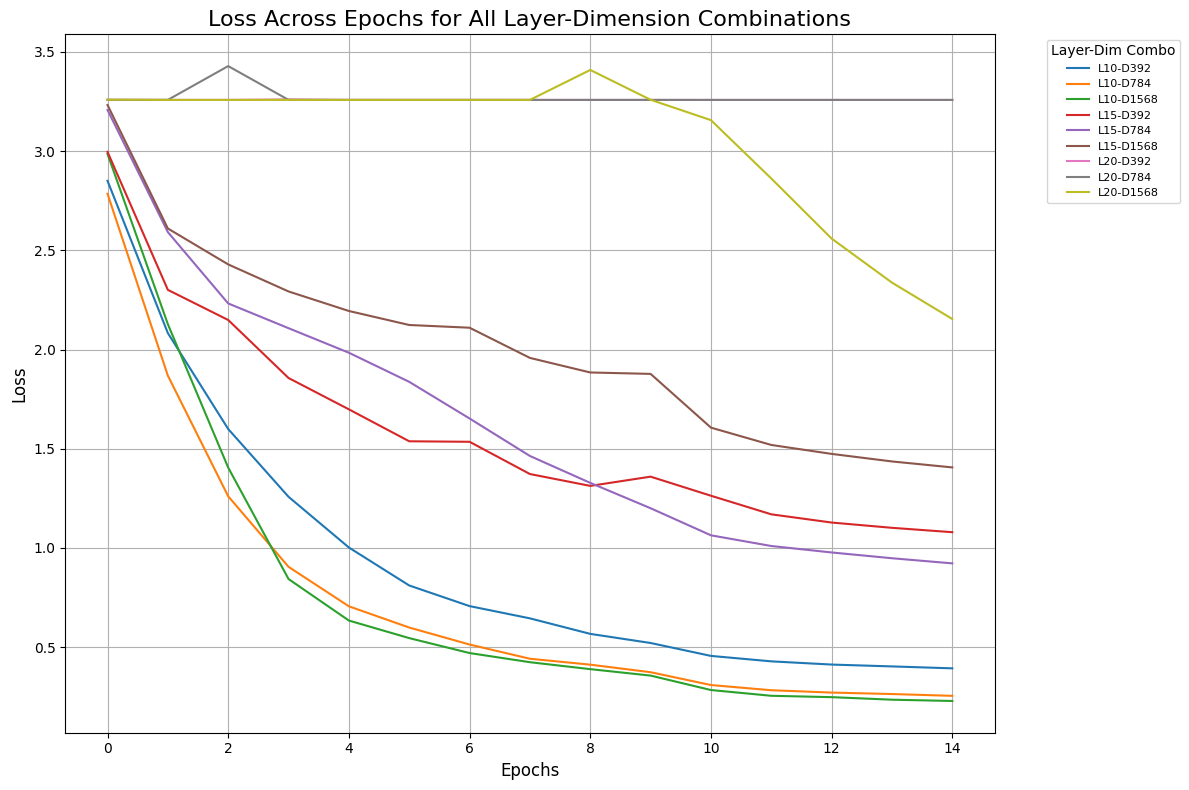

In [7]:
plt.figure(figsize=(12, 8))
hidden_dims = [int(28 * 28 * 0.5), 28 * 28, 28 * 28 * 2]

for i, layer in enumerate(hidden_layers):
    for j, dim in enumerate(hidden_dims):
        plt.plot(range(len(layer_dim_loss[i][j])), layer_dim_loss[i][j], label=f"L{layer}-D{dim}")

plt.title("Loss Across Epochs for All Layer-Dimension Combinations", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Layer-Dim Combo", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

### Finding Best Model Based on Testing Accuracy

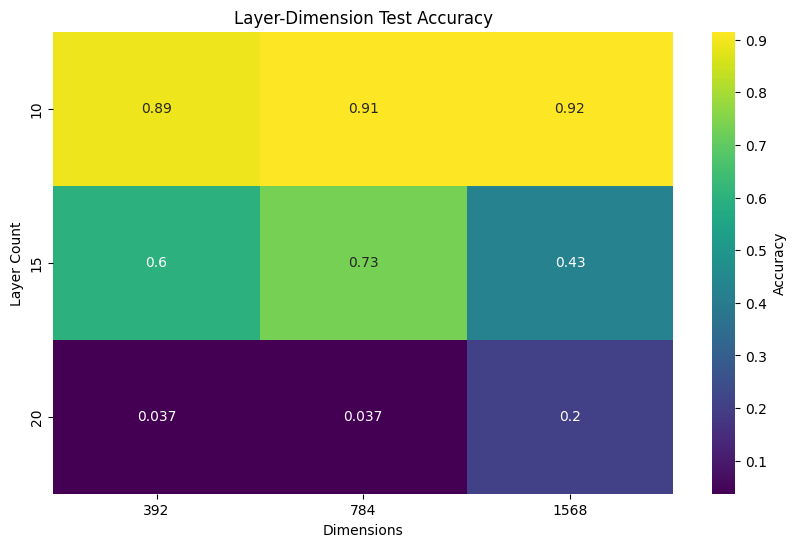

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(layer_dim_accuracy, annot=True, cmap="viridis", cbar_kws={'label': 'Accuracy'}, xticklabels=hidden_dims, yticklabels=hidden_layers)
plt.title("Layer-Dimension Test Accuracy")
plt.xlabel("Dimensions")
plt.ylabel("Layer Count")
plt.show()

Training bigger networks is more difficult and requires the utilization of training tricks to make gradients propogate smoothly. So when using more and more layers we see a decrease in performance while increasing the hidden dimensions gives us an increase in performance over a specific layer count.

In [55]:
class CNN(nn.Module):
    def __init__(self, hidden_dim1, hidden_dim2, dropout):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, hidden_dim1, kernel_size=(4, 4), padding=(1, 1), stride = (1, 1)),
            nn.BatchNorm2d(hidden_dim1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)),
            nn.Conv2d(hidden_dim1, hidden_dim2, kernel_size=(4, 4), padding=(1, 1), stride = (1, 1)),
            nn.BatchNorm2d(hidden_dim2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)),
            nn.Conv2d(hidden_dim2, hidden_dim2, kernel_size=(4, 4), padding=(1, 1), stride = (1, 1)),
            nn.BatchNorm2d(hidden_dim2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        )

        self.classifier = nn.Sequential(
            nn.Linear(11 * 11 * hidden_dim2, 1024),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 26)
        )

    def forward(self, vals: torch.Tensor, targets: torch.Tensor = None):
        logits = self.classifier(self.features(vals).view(vals.shape[0], -1))

        if targets != None:
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss

In [10]:
learning_rate = 0.001

hidden_dims = [(16, 32), (32, 64), (48, 96)]
epoch_counts = [10, 15, 20]
epoch_dim_loss = [] # Will be 3D array with rows being loss of a layer count vs all dims
epoch_dim_accuracy = [] # Will be 2D array with rows being test accuracy of a layer count vs all dims

for e in epoch_counts:
    epoch_loss = []
    epoch_accuracy = []

    for dim1, dim2 in hidden_dims:
        model = CNN(dim1, dim2, 0.4)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_arr = train_model(model, e, train_loader, optimizer, cnn=True)
        epoch_loss.append(loss_arr)

        with torch.no_grad():
            epoch_accuracy.append(test_accuracy(model, test_loader, cnn=True).item())

    epoch_dim_loss.append(epoch_loss)
    epoch_dim_accuracy.append(epoch_accuracy)

122it [00:12, 10.15it/s]


Epoch 1: 0.5580653206246798


122it [00:10, 11.85it/s]


Epoch 2: 0.22816381298127722


122it [00:10, 11.54it/s]


Epoch 3: 0.1908626087376329


122it [00:10, 11.56it/s]


Epoch 4: 0.16965481492339587


122it [00:10, 11.71it/s]


Epoch 5: 0.15521643591708825


122it [00:12,  9.63it/s]


Epoch 6: 0.14498749717337187


122it [00:10, 11.61it/s]


Epoch 7: 0.13359390321325082


122it [00:10, 11.67it/s]


Epoch 8: 0.12548717123563172


122it [00:10, 11.58it/s]


Epoch 9: 0.1210619035314341


122it [00:10, 11.79it/s]


Epoch 10: 0.11270258856601402


0it [00:00, ?it/s]/home/pmoha/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
122it [00:10, 11.15it/s]


Epoch 1: 0.6519957370445376


122it [00:10, 11.63it/s]


Epoch 2: 0.2382651626086626


122it [00:10, 11.34it/s]


Epoch 3: 0.19495441874519723


122it [00:10, 11.56it/s]


Epoch 4: 0.17685338317370805


122it [00:10, 11.57it/s]


Epoch 5: 0.16027012809378202


122it [00:10, 11.63it/s]


Epoch 6: 0.14903382785984728


122it [00:10, 11.41it/s]


Epoch 7: 0.14068570684214107


122it [00:10, 11.73it/s]


Epoch 8: 0.13270423451408012


122it [00:10, 11.38it/s]


Epoch 9: 0.12592558782608781


122it [00:10, 11.46it/s]


Epoch 10: 0.12019411462252258


122it [00:11, 10.29it/s]


Epoch 1: 0.9441038037909836


122it [00:13,  8.78it/s]


Epoch 2: 0.25542759504474577


122it [00:11, 10.26it/s]


Epoch 3: 0.207693522093726


122it [00:11, 10.33it/s]


Epoch 4: 0.1879232906904377


122it [00:11, 10.57it/s]


Epoch 5: 0.17290789182068872


122it [00:10, 11.21it/s]


Epoch 6: 0.15607635310438814


122it [00:11, 10.20it/s]


Epoch 7: 0.14844450403432377


122it [00:11, 10.56it/s]


Epoch 8: 0.1431160285824635


122it [00:11, 10.80it/s]


Epoch 9: 0.13498733082755668


122it [00:11, 10.47it/s]


Epoch 10: 0.12720666947911996


122it [00:10, 11.64it/s]


Epoch 1: 0.6365630978443584


122it [00:10, 11.46it/s]


Epoch 2: 0.23657209365094295


122it [00:10, 11.58it/s]


Epoch 3: 0.1971335645581855


122it [00:10, 11.47it/s]


Epoch 4: 0.17541402285216284


122it [00:10, 11.79it/s]


Epoch 5: 0.1614950524001825


122it [00:10, 11.71it/s]


Epoch 6: 0.14789487494797002


122it [00:10, 11.60it/s]


Epoch 7: 0.1387921317678983


122it [00:10, 11.71it/s]


Epoch 8: 0.1313765166235752


122it [00:10, 11.53it/s]


Epoch 9: 0.12440052188810755


122it [00:10, 11.61it/s]


Epoch 10: 0.11561593071359103


122it [00:10, 11.50it/s]


Epoch 11: 0.09430385808475682


122it [00:10, 11.66it/s]


Epoch 12: 0.08645759645055552


122it [00:10, 11.70it/s]


Epoch 13: 0.08284844726812644


122it [00:10, 11.77it/s]


Epoch 14: 0.08116900334592725


122it [00:10, 11.69it/s]


Epoch 15: 0.07896810281472127


122it [00:15,  7.87it/s]


Epoch 1: 0.651922194684138


122it [00:10, 11.43it/s]


Epoch 2: 0.23603981831034676


122it [00:10, 11.38it/s]


Epoch 3: 0.19557061742563717


122it [00:10, 11.55it/s]


Epoch 4: 0.17601824588462955


122it [00:10, 11.46it/s]


Epoch 5: 0.1609249427670338


122it [00:10, 11.30it/s]


Epoch 6: 0.14842736916463883


122it [00:10, 11.48it/s]


Epoch 7: 0.14117025156490137


122it [00:10, 11.64it/s]


Epoch 8: 0.13140348528252274


122it [00:10, 11.58it/s]


Epoch 9: 0.12668755797089123


122it [00:10, 11.53it/s]


Epoch 10: 0.1190106204298676


122it [00:10, 11.42it/s]


Epoch 11: 0.09503891428963082


122it [00:10, 11.35it/s]


Epoch 12: 0.0866422731368268


122it [00:10, 11.49it/s]


Epoch 13: 0.08372289626324764


122it [00:10, 11.51it/s]


Epoch 14: 0.08135349242413631


122it [00:10, 11.33it/s]


Epoch 15: 0.07879297068861664


122it [00:11, 10.77it/s]


Epoch 1: 0.7528124324610976


122it [00:11, 10.31it/s]


Epoch 2: 0.24368361176037398


122it [00:12,  9.91it/s]


Epoch 3: 0.2028787175162894


122it [00:12, 10.15it/s]


Epoch 4: 0.18341300526603324


122it [00:12,  9.73it/s]


Epoch 5: 0.1675480076524078


122it [00:11, 10.78it/s]


Epoch 6: 0.15518857611984502


122it [00:11, 10.70it/s]


Epoch 7: 0.1496531533413246


122it [00:11, 10.27it/s]


Epoch 8: 0.13840955202696753


122it [00:12, 10.05it/s]


Epoch 9: 0.1318759292852683


122it [00:11, 10.48it/s]


Epoch 10: 0.12656150098706856


122it [00:11, 10.89it/s]


Epoch 11: 0.10097600592941534


122it [00:11, 10.48it/s]


Epoch 12: 0.0924819492902912


122it [00:11, 10.55it/s]


Epoch 13: 0.0885298134850674


122it [00:12,  9.80it/s]


Epoch 14: 0.08600281105666864


122it [00:11, 10.75it/s]


Epoch 15: 0.08425263107800093


122it [00:12,  9.61it/s]


Epoch 1: 0.5777671063532595


122it [00:10, 11.47it/s]


Epoch 2: 0.23203813834268538


122it [00:10, 11.57it/s]


Epoch 3: 0.19368836137114978


122it [00:10, 11.48it/s]


Epoch 4: 0.1719643014376281


122it [00:10, 11.54it/s]


Epoch 5: 0.1583225375316182


122it [00:10, 11.65it/s]


Epoch 6: 0.14750982503421972


122it [00:10, 11.57it/s]


Epoch 7: 0.1359784016843702


122it [00:10, 11.48it/s]


Epoch 8: 0.12894883703012935


122it [00:10, 11.60it/s]


Epoch 9: 0.12219373515394867


122it [00:10, 11.29it/s]


Epoch 10: 0.11496979291321802


122it [00:10, 11.66it/s]


Epoch 11: 0.09229182415321226


122it [00:10, 11.57it/s]


Epoch 12: 0.08404955316762455


122it [00:10, 11.49it/s]


Epoch 13: 0.08096873173948194


122it [00:10, 11.62it/s]


Epoch 14: 0.07856705149666207


122it [00:10, 11.69it/s]


Epoch 15: 0.0766506664088515


122it [00:10, 11.38it/s]


Epoch 16: 0.07555645020281682


122it [00:10, 11.52it/s]


Epoch 17: 0.07347075665583376


122it [00:10, 11.58it/s]


Epoch 18: 0.0715935191170114


122it [00:10, 11.73it/s]


Epoch 19: 0.07023946574476898


122it [00:10, 11.68it/s]


Epoch 20: 0.06893277559124056


122it [00:11, 10.95it/s]


Epoch 1: 0.7191532947978035


122it [00:10, 11.35it/s]


Epoch 2: 0.23826561599481302


122it [00:10, 11.36it/s]


Epoch 3: 0.19612922043096823


122it [00:10, 11.55it/s]


Epoch 4: 0.17532545621277856


122it [00:10, 11.38it/s]


Epoch 5: 0.16176533308185514


122it [00:10, 11.57it/s]


Epoch 6: 0.1501415596633661


122it [00:10, 11.44it/s]


Epoch 7: 0.1410128484006788


122it [00:10, 11.42it/s]


Epoch 8: 0.13625015196253043


122it [00:10, 11.46it/s]


Epoch 9: 0.1284868209088435


122it [00:10, 11.54it/s]


Epoch 10: 0.12236926594718558


122it [00:10, 11.39it/s]


Epoch 11: 0.09694812336906058


122it [00:10, 11.37it/s]


Epoch 12: 0.08805027164396692


122it [00:10, 11.43it/s]


Epoch 13: 0.08567600562924245


122it [00:10, 11.37it/s]


Epoch 14: 0.08326982279292873


122it [00:10, 11.39it/s]


Epoch 15: 0.08140173114714075


122it [00:10, 11.38it/s]


Epoch 16: 0.0788789264491347


122it [00:10, 11.56it/s]


Epoch 17: 0.07733203543991339


122it [00:10, 11.36it/s]


Epoch 18: 0.07606641581801117


122it [00:10, 11.31it/s]


Epoch 19: 0.07480304749285588


122it [00:10, 11.19it/s]


Epoch 20: 0.0727328785130235


122it [00:12,  9.93it/s]


Epoch 1: 0.7711318594510438


122it [00:11, 10.94it/s]


Epoch 2: 0.24440726295846407


122it [00:11, 10.50it/s]


Epoch 3: 0.2032449284537894


122it [00:11, 10.91it/s]


Epoch 4: 0.18214948060082609


122it [00:11, 10.99it/s]


Epoch 5: 0.16554363438340483


122it [00:12, 10.11it/s]


Epoch 6: 0.154657817277752


122it [00:11, 10.98it/s]


Epoch 7: 0.14656060640929175


122it [00:12,  9.80it/s]


Epoch 8: 0.13622695109883293


122it [00:12,  9.94it/s]


Epoch 9: 0.1305196011652712


122it [00:11, 10.33it/s]


Epoch 10: 0.12364871384667568


122it [00:11, 10.99it/s]


Epoch 11: 0.09820446420888432


122it [00:10, 11.09it/s]


Epoch 12: 0.08985061332827708


122it [00:12, 10.04it/s]


Epoch 13: 0.08569014658693408


122it [00:11, 10.82it/s]


Epoch 14: 0.08323640510684154


122it [00:11, 10.63it/s]


Epoch 15: 0.08099192478617684


122it [00:11, 10.69it/s]


Epoch 16: 0.08039282189040887


122it [00:11, 10.81it/s]


Epoch 17: 0.07881967356947601


122it [00:11, 10.62it/s]


Epoch 18: 0.07668639792770636


122it [00:11, 10.95it/s]


Epoch 19: 0.0750454840112905


122it [00:11, 10.28it/s]


Epoch 20: 0.07283789994286709


### Finding Best Model Based on Testing Accuracy

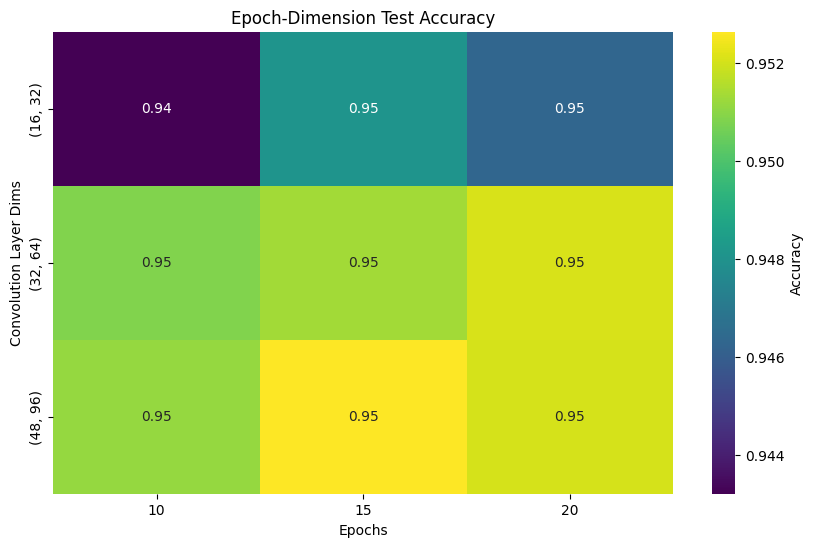

In [11]:
hidden_dims = [(16, 32), (32, 64), (48, 96)]

plt.figure(figsize=(10, 6))
sns.heatmap(epoch_dim_accuracy, annot=True, cmap="viridis", cbar_kws={'label': 'Accuracy'}, xticklabels=epoch_counts, yticklabels=hidden_dims)
plt.title("Epoch-Dimension Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Convolution Layer Dims")
plt.show()

In [9]:
model = MLP(28 * 28, 28 * 28 * 2, 10)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_arr = train_model(model, 15, train_loader, optimizer, 28 * 28)

with torch.no_grad():
    print(test_accuracy(model, test_loader, 28 * 28).item())

122it [00:11, 10.57it/s]


Epoch 1: 3.1470459484663165


122it [00:10, 11.18it/s]


Epoch 2: 2.229530459544698


122it [00:10, 11.20it/s]


Epoch 3: 1.2858252603499616


122it [00:11, 10.80it/s]


Epoch 4: 0.8023909271740522


122it [00:10, 11.24it/s]


Epoch 5: 0.6037706468926102


122it [00:10, 11.25it/s]


Epoch 6: 0.500567545656298


122it [00:11, 10.95it/s]


Epoch 7: 0.44236042460457226


122it [00:10, 11.30it/s]


Epoch 8: 0.39948816768458634


122it [00:10, 11.46it/s]


Epoch 9: 0.367710645081567


122it [00:10, 11.14it/s]


Epoch 10: 0.34850971034315764


122it [00:10, 11.44it/s]


Epoch 11: 0.2865790070080366


122it [00:10, 11.14it/s]


Epoch 12: 0.24947454108566533


122it [00:11, 10.94it/s]


Epoch 13: 0.23784806298427894


122it [00:10, 11.41it/s]


Epoch 14: 0.23066938118856462


122it [00:11, 11.07it/s]


Epoch 15: 0.2204027332243372
0.9180710315704346


In [59]:
cnn_model = CNN(48, 96, 0.4)
cnn_model.to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
loss_arr = train_model(cnn_model, 15, train_loader, optimizer, cnn=True)

with torch.no_grad():
    print(test_accuracy(cnn_model, test_loader, cnn=True).item())

122it [00:10, 11.33it/s]


Epoch 1: 0.759714032782883


122it [00:10, 11.36it/s]


Epoch 2: 0.238115201230909


122it [00:10, 11.40it/s]


Epoch 3: 0.2020541175467069


122it [00:10, 11.36it/s]


Epoch 4: 0.1786485890873143


122it [00:10, 11.46it/s]


Epoch 5: 0.166690607539943


122it [00:10, 11.55it/s]


Epoch 6: 0.15383920513215613


122it [00:10, 11.46it/s]


Epoch 7: 0.14513245566946562


122it [00:10, 11.30it/s]


Epoch 8: 0.1382208495843606


122it [00:10, 11.55it/s]


Epoch 9: 0.13033724612877018


122it [00:10, 11.54it/s]


Epoch 10: 0.12493243764658443


122it [00:11, 11.07it/s]


Epoch 11: 0.09918701453287093


122it [00:10, 11.38it/s]


Epoch 12: 0.09050166802328141


122it [00:10, 11.57it/s]


Epoch 13: 0.0875486858555528


122it [00:10, 11.38it/s]


Epoch 14: 0.08435604220531026


122it [00:10, 11.25it/s]


Epoch 15: 0.08245057747012279
0.9516834020614624


/home/pmoha/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


### Validating with Additional Data

In [14]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split

In [15]:
path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")
csv_path = path + "/english.csv"

In [52]:
img_class = pd.read_csv(csv_path)
img_class.head()
images = img_class["image"]
labels = img_class["label"]
new_images = []
new_labels = []

new_images_bordered = []
new_labels_bordered = []

for index, label in enumerate(labels):
    
    if label.isnumeric():
        continue
    if label.isupper():
        label_index = ord(label) - ord("A") + 1
    if label.islower():
        label_index = ord(label) - ord("a") + 1

    image_path = os.path.join(path, images[index])
    img = Image.open(image_path).convert('L')
    # plt.imshow(img)
    img = img.resize((44, 44))
    np_array = np.array(img)

    crop_size = 28
    start = (44 - crop_size) // 2
    cropped_array = np_array[start:start+crop_size, start:start+crop_size]
    inverted_np_array = (255 - cropped_array) / 255
    rotated_array = inverted_np_array.T

    new_images.append(rotated_array)
    new_labels.append(label_index)

    border_thickness = 1
    top_border = rotated_array[:border_thickness, :]
    bottom_border = rotated_array[-border_thickness:, :]
    left_border = rotated_array[:, :border_thickness]
    right_border = rotated_array[:, -border_thickness:]

    if (np.any(top_border != 0) or np.any(bottom_border != 0) or 
        np.any(left_border != 0) or np.any(right_border != 0)):
        continue
    # plt.imshow(inverted_np_array, cmap='gray')
    # break

    new_images_bordered.append(rotated_array)
    new_labels_bordered.append(label_index)

len(new_images), len(new_images_bordered)

(2860, 1452)

In [60]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

dataset = ImageDataset(new_images, new_labels)
dataset_bordered = ImageDataset(new_images_bordered, new_labels_bordered)

# for temp, i in enumerate(dataset):
#     label = i[1]
#     if label != 2:
#         continue
#     print(label)
#     print(chr(ord("a") + label - 1))
#     image = i[0].numpy()[0]
#     plt.imshow(image, cmap="gray")
#     break

# print(torch.argmax(torch.sigmoid(model(i[0].view(-1).to(device))[0])))

external_data_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)
external_data_loader_bordered = DataLoader(dataset_bordered, batch_size=32, shuffle=True, pin_memory=True)

print(f"External Data Loader Size: {len(external_data_loader)} batches")
print(f"External Data Loader Bordered Size: {len(external_data_loader_bordered)} batches")

with torch.no_grad():
    print("External Data Accuracy (MLP): ", test_accuracy(model, external_data_loader, 28 * 28).item())
    print("External Data Bordered Accuracy (MLP): ", test_accuracy(model, external_data_loader_bordered, 28 * 28).item())

    print("External Data Accuracy (CNN): ", test_accuracy(cnn_model, external_data_loader, cnn=True).item())
    print("External Data Bordered Accuracy (CNN): ", test_accuracy(cnn_model, external_data_loader_bordered, cnn=True).item())

External Data Loader Size: 90 batches
External Data Loader Bordered Size: 46 batches
External Data Accuracy (MLP):  0.45798611640930176
External Data Bordered Accuracy (MLP):  0.4268568754196167
External Data Accuracy (CNN):  0.719328761100769
External Data Bordered Accuracy (CNN):  0.7194293737411499
